# Steam Reviews Analysis using Natural Language Processing (NLP) for Warhammer 40K: Space Marine 2

# Objective
Warhammer 40,000: Space Marine 2 has recently launched to widespread acclaim at the time of publishing this notebook, earning a 'Very Positive' rating on Steam with over 41,000 positive reviews. However, more than 10,000 players have expressed dissatisfaction in negative reviews, citing issues such as crashes, lack of ultrawide support, and various bugs.

The objective of this notebook is to efficiently analyze and identify the key concerns raised by the community. This will enable developers to quickly address critical issues, minimizing time spent filtering through reviews and maximizing focus on delivering timely patches and improvements.

#### Tools and Technologies
- Programming Language: Python
- Data Collection: Scraped Warhammer 40,000: Space Marine 2 Steam Reviews
- Data Analysis: Pandas, NumPy, Scikit-learn
- Data Processing: Natural Language Processing (NLP), N-gram extraction, TF-IDF (Term Frequency-Inverse Document Frequency)
- Visualization: Matplotlib, Seaborn

# 0. Import Necessary Packages

In [1]:
import json
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from itertools import chain

In [2]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\josht\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\josht\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josht\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load spaCy language model
nlp = spacy.load('en_core_web_sm')

</br>

# 1. Data Collection

The steam reviews have been collected using [Steam Game Review Scraper](https://github.com/israel-dryer/Steam-Game-Review-Scraper) by [Israel Dryer](https://github.com/israel-dryer), which I updated to work with [Selenium 4](https://www.selenium.dev/documentation/webdriver/troubleshooting/upgrade_to_selenium_4/). The dataset includes over 16,000 reviews with both 'Recommended' and 'Not Recommended' entries that have been sorted by 'Most Helpful' to try and filter for the most beneficial feedback for developers 

The dataset consists of the following features:
- SteamId
- ProfileURL
- ReviewText
- Review
- ReviewLength
- PlayHours
- DatePosted

## 1.1 Import csv

In [4]:
df_recommended = pd.read_csv('SP2_steam_reviews_recommended.csv')
df_not_recommended = pd.read_csv('SP2_steam_reviews_not_recommended.csv')

# Concat the imported dataframes
df = pd.concat([df_recommended, df_not_recommended])

## 1.2 Rename features

In [5]:
df = df.rename(columns={
    'SteamId': 'steam_id',
    'ProfileURL': 'profile_url',
    'ReviewText': 'review_text',
    'Review': 'review',
    'ReviewLength(Chars)': 'review_length',
    'PlayHours': 'play_hours',
    'DatePosted': 'date_posted'
})

<br>

# 2. Data Cleaning and Preprocessing

In [6]:
df.head()

,steam_id,profile_url,review_text,review,review_length,play_hours,date_posted
0,wabungo,https://steamcommunity.com/id/wabungo/,this game feels like it was made in the mid 20...,Recommended,69,7.0 hrs on record,Posted: September 14
1,JekFighter,https://steamcommunity.com/id/JekFighter/,Reminds me of something I've lost. A genuine g...,Recommended,79,9.0 hrs on record,Posted: September 12
2,76561198050419580,https://steamcommunity.com/profiles/7656119805...,Listen brothers! I have waited more than 10 ye...,Recommended,3661,53.3 hrs on record,Posted: September 10
3,76561198014929285,https://steamcommunity.com/profiles/7656119801...,Summary\nCampaign: <15 hours of loreful hack n...,Recommended,2920,26.0 hrs on record,Posted: September 9
4,icebalm,https://steamcommunity.com/id/icebalm/,"Campaign is short, but gameplay is fun. Maybe ...",Recommended,89,22.8 hrs on record,Posted: September 11


## 2.1 Cleaning and transformation to be done

Steam Id
- Drop feature

Profile Url
- Drop feature

Review Text
- Drop NaN
- Tokenization (Break down each review into individual words)
- Values that are removed through tokenization (e.g. emojis or randomw keyboard spam) will need to be dropped
- Stopwords removal (Remove common words like "and," "the," "is" that don’t add much meaning)
- Lemmatization (Reduce words to their base forms)

Play Hours
- Remove 'hrs on record'
- Convert to float

Date Posted
- Remove 'Posted:'
- Add 2024
- Convert to datetime

## 2.2 Preprocessing transformers

In [7]:
# Define a transformer to drop NaN and empty values
class DropNaNTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Drop rows where 'review_text' is NaN or contains only whitespace
        X_cleaned = X.dropna(subset=['review_text'])  # Drop rows with NaN in 'review_text'
        X_cleaned = X_cleaned[X_cleaned['review_text'].str.strip() != '']  # Remove rows with empty or whitespace-only 'review_text'
        
        return X_cleaned

In [8]:
# Transformer to drop unnecessary columns
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns, errors='ignore')

In [9]:
# Define transformer to clean Review Text
class ReviewTextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Apply cleaning to the 'review_text' column in the DataFrame
        X_cleaned = X.copy()
        # Apply _clean_text to each entry in the 'review_text' column
        X_cleaned['review_text'] = X_cleaned['review_text'].apply(self._clean_text)
        return X_cleaned
    
    def _clean_text(self, text):
        # Only process valid strings
        if isinstance(text, str):
            # Tokenization: Split the text into words (tokens) and lowercase it
            tokens = word_tokenize(text.lower())
            
            # Stopwords removal and lemmatization
            cleaned_tokens = [self.lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in self.stop_words]
            
            # Return the cleaned tokens if not empty, otherwise return None
            return cleaned_tokens if cleaned_tokens else None
        else:
            # Return None for non-string values
            return None

In [10]:
# Define transformer to drop rows with empty or None from 'review_text'
class DropEmptyRowsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Drop rows where 'review_text' is None or empty
        X_cleaned = X.dropna(subset=['review_text'])  # Drop rows with None in 'review_text'
        X_cleaned = X_cleaned[X_cleaned['review_text'].str.strip() != '']  # Remove rows with empty or whitespace-only 'review_text'
        
        return X_cleaned

In [11]:
# Define transformer to clean Play Hours
class PlayHoursCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Ensure we're applying the transformation only to the 'play_hours' column
        X_cleaned = X.copy()
        X_cleaned['play_hours'] = X_cleaned['play_hours'].apply(self._clean_hours)
        return X_cleaned
    
    def _clean_hours(self, text):
        # Extract float hours from 'hrs on record'
        match = re.findall(r"\d+\.\d+", str(text))  # Convert to string to avoid errors
        return float(match[0]) if match else 0.0

In [12]:
# Define transformer to clean Date Posted
class DatePostedCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, year=2024):
        self.year = year
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Apply cleaning to the 'date_posted' column in the DataFrame
        X_cleaned = X.copy()
        X_cleaned['date_posted'] = X_cleaned['date_posted'].apply(self._clean_date)
        
        return X_cleaned
    
    def _clean_date(self, text):
        # Remove 'Posted:' and strip any extra spaces
        clean_text = text.replace("Posted:", "").strip()
        
        # Append the year (2024) to make it a valid date
        full_date = f"{clean_text} {self.year}"
        
        # Convert to datetime
        return pd.to_datetime(full_date, format='%B %d %Y', errors='coerce')

In [13]:
# Define transformer to handle outliers
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Make a copy of the DataFrame
        X_cleaned = X.copy()
        
        # Define the columns to handle outliers: 'review_length' and 'play_hours'
        columns = ['review_length', 'play_hours']
        
        # Loop through the specified columns and remove outliers
        for col in columns:
            Q1 = X_cleaned[col].quantile(0.25)  # First quartile
            Q3 = X_cleaned[col].quantile(0.75)  # Third quartile
            IQR = Q3 - Q1  # Interquartile range
            lower_bound = Q1 - self.factor * IQR  # Lower bound
            upper_bound = Q3 + self.factor * IQR  # Upper bound
            
            # Remove rows where values are below the lower bound or above the upper bound
            X_cleaned = X_cleaned[(X_cleaned[col] >= lower_bound) & (X_cleaned[col] <= upper_bound)]
        
        return X_cleaned

## 2.3 Full pipeline

In [14]:
# Build the pipeline
pipeline = Pipeline([
    ('drop_nan', DropNaNTransformer()),  # First step: drop NaN and empty values
    ('drop_columns', DropColumnsTransformer(columns=['steam_id', 'profile_url'])),
    ('review_cleaner', ReviewTextCleaner()),  # Clean the review text
    ('drop_empty_reviews', DropEmptyRowsTransformer()),  # Drop rows with empty or None review_text after cleaning
    ('play_hours_cleaner', PlayHoursCleaner()),  # Clean the play hours column
    ('outlier_handler', OutlierHandler(factor=1.5)),  # Handle outliers for review_length and play_hours
    ('date_posted_cleaner', DatePostedCleaner())  # Clean the date posted column
])

In [15]:
# Apply the full pipeline to the dataset
df_cleaned = pipeline.fit_transform(df)

## 2.4 Save cleaned data

In [16]:
# Save the cleaned data
df_cleaned.to_csv("Cleaned_Steam_Reviews_Warhammer_Space_Marine_2.csv", index=False)

</br>

# 3. Exploratory Data Analysis

In [17]:
df = pd.read_csv("Cleaned_Steam_Reviews_Warhammer_Space_Marine_2.csv")

## 3.1 General analysis

In [18]:
df.head()

,review_text,review,review_length,play_hours,date_posted
0,"['game', 'feel', 'like', 'made', 'mid', '2010'...",Recommended,69,7.0,2024-09-14
1,"['reminds', 'something', 'lost', 'genuine', 'g...",Recommended,79,9.0,2024-09-12
2,"['campaign', 'short', 'gameplay', 'fun', 'mayb...",Recommended,89,22.8,2024-09-11
3,"['game', 'also', 'super', 'fun', 'pvp', 'campa...",Recommended,435,21.9,2024-09-14
4,"['finally', 'solid', 'game', 'solid', 'gamepla...",Recommended,232,33.1,2024-09-07


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14158 entries, 0 to 14157
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   review_text    14158 non-null  object 
 1   review         14158 non-null  object 
 2   review_length  14158 non-null  int64  
 3   play_hours     14158 non-null  float64
 4   date_posted    14158 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 553.2+ KB


In [20]:
df.describe()

,review_length,play_hours
count,14158.000000,14158.000000
mean,155.751377,21.355432
std,173.658101,16.633486
min,1.000000,0.100000
25%,27.000000,8.800000
50%,84.000000,17.200000
75%,225.000000,31.000000
max,750.000000,70.600000


## 3.2 Functions to explore each feature

### 3.2.1 Univariate functions

In [21]:
# Function that will return the value count and frequency of each observation within a feature
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [22]:
# Function to create display general information about the feature
def gen_info_feat(df,feature):
    print(f'Description:\n{df[feature].describe()}')
    print('*'*50)
    print(f'Object type: {df[feature].dtype}')

In [23]:
# Function to create a pie chart plot
def create_pie_plot(df,feature):
    ratio_size = value_cnt_norm_cal(df, feature)
    ratio_size_len = len(ratio_size.index)
    ratio_list = []
    for i in range(ratio_size_len):
        ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
    fig, ax = plt.subplots(figsize=(10,4))
    # %1.2f%% display decimals in the pie chart with 2 decimal places
    plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
    
    feature_label = feature.capitalize().replace('_', ' ')
    
    plt.title(f'Pie Chart of {feature_label}')
    plt.legend(loc='best')
    plt.axis('equal')
    return plt.show()

In [24]:
# Function to create a bar chart plot
def create_bar_plot(df, feature):
    fig, ax = plt.subplots(figsize=(4, 6))
    feature_label = feature.capitalize().replace('_', ' ')
    
    # Get value counts for the feature (normalize as needed)
    value_counts = value_cnt_norm_cal(df, feature)
    
    # Create the bar plot
    sns.barplot(x=value_counts.index, y=value_counts.values[:, 0], ax=ax)
    plt.xlabel(f'{feature_label}')
    
    # Rotate labels if there are 5 or more unique values in the feature
    if df[feature].nunique() >= 5:  # Check the number of unique values in the feature
        plt.xticks(rotation=45)
    else:
        plt.xticks(rotation=0)
        
    plt.ylabel('Count')
    plt.title(f'{feature_label} Count')
    
    return plt.show()

In [25]:
# Function to create a box plot
def create_box_plot(df,feature):
    fig, ax = plt.subplots(figsize=(3, 5))
    sns.boxplot(y=df[feature])

    feature_label = feature.capitalize().replace('_', ' ')
    plt.title(f'{feature_label} Boxplot Distribution')
    return plt.show()

In [26]:
# Function to create a histogram plot
def create_hist_plot(df,feature, the_bins=50):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(df[feature],bins=the_bins,kde=True)
    feature_label = feature.capitalize().replace('_', ' ')
    plt.title(f'{feature_label}')
    return plt.show()

### 3.2.2 Bivariate functions

In [27]:
# Function to create a bar plot for two features
def create_bar_plot_bi(df, feature_1, feature_2):
    sns.boxplot(x=df[feature_1], y=df[feature_2], hue=df[feature_1])
    
    feature_1_label = feature_1.capitalize().replace('_', ' ')
    feature_2_label = feature_2.capitalize().replace('_', ' ')
    
    plt.title(f'{feature_1_label} vs. {feature_2_label}')
    plt.xlabel(f'{feature_1_label}')
    plt.ylabel(f'{feature_2_label}')
    
    return plt.show()

In [28]:
# Function to create a line plot that shows review type across dates
def create_line_plot_reviews(df, review_col, date_col):
    review_trend = df.groupby([pd.Grouper(key=date_col), review_col]).size().unstack(fill_value=0)
    
    review_trend.plot(kind='line', figsize=(9, 5))
    
    plt.title('Review Type Over Time')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Reviews', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Review Type', fontsize=10)

    plt.tight_layout()
    return plt.show()

In [29]:
# Function to create a scatter plot for two numerical features
def create_scatter_plot(df, feature_1, feature_2):
    plt.figure(figsize=(8, 6))
    
    sns.scatterplot(x=df[feature_1], y=df[feature_2], alpha=0.6)
    
    feature_1_label = feature_1.capitalize().replace('_', ' ')
    feature_2_label = feature_2.capitalize().replace('_', ' ')
    
    plt.title(f'{feature_1_label} vs. {feature_2_label}')
    plt.xlabel(f'{feature_1_label}')
    plt.ylabel(f'{feature_2_label}')
    
    return plt.show()

### 3.2.3 Correlation function

In [30]:
# Function to create a correlation matrix with review as a target
def plot_correlation_matrix(df, target_col='review'):
    df_corr = df.copy()
    
    # Convert the target column to numerical if it's categorical
    if df_corr[target_col].dtype == 'object':
        df_corr[target_col] = df_corr[target_col].apply(lambda x: 1 if x == 'Recommended' else 0)
    
    # Select only the numerical columns (including the target column)
    numerical_cols = df_corr.select_dtypes(include=['float64', 'int64']).columns.tolist() + [target_col]
    
    # Compute the correlation matrix for numerical columns
    corr_matrix = df_corr[numerical_cols].corr()
    
    # Create a mask for the upper triangle of the matrix
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=(6, 4))
    
    # Draw the heatmap with the mask
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .8}, linewidths=0.5)
    
    plt.title(f'Correlation Matrix with Target Variable: {target_col}', fontsize=14)

    return plt.show()

## 3.3 Univariate analysis

### 3.3.1 Review

In [31]:
gen_info_feat(df, 'review')

Description:
count           14158
unique              2
top       Recommended
freq             8666
Name: review, dtype: object
**************************************************
Object type: object


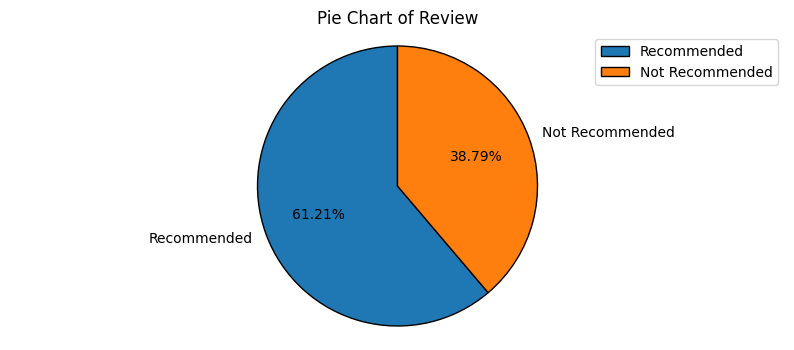

In [32]:
create_pie_plot(df, 'review')

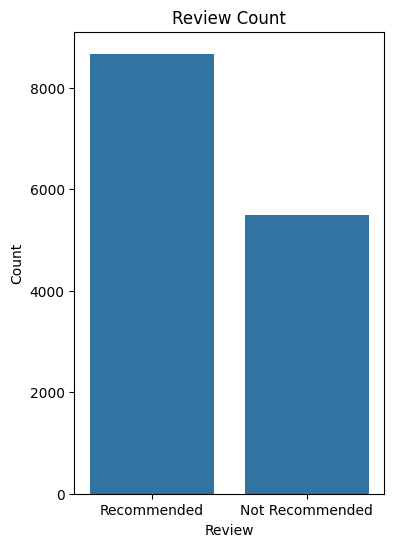

In [33]:
create_bar_plot(df, 'review')

Interpretation
- 61% of the data includes 'Recommended' reviews

### 3.3.2 Review Length

In [34]:
gen_info_feat(df, 'review_length')

Description:
count    14158.000000
mean       155.751377
std        173.658101
min          1.000000
25%         27.000000
50%         84.000000
75%        225.000000
max        750.000000
Name: review_length, dtype: float64
**************************************************
Object type: int64


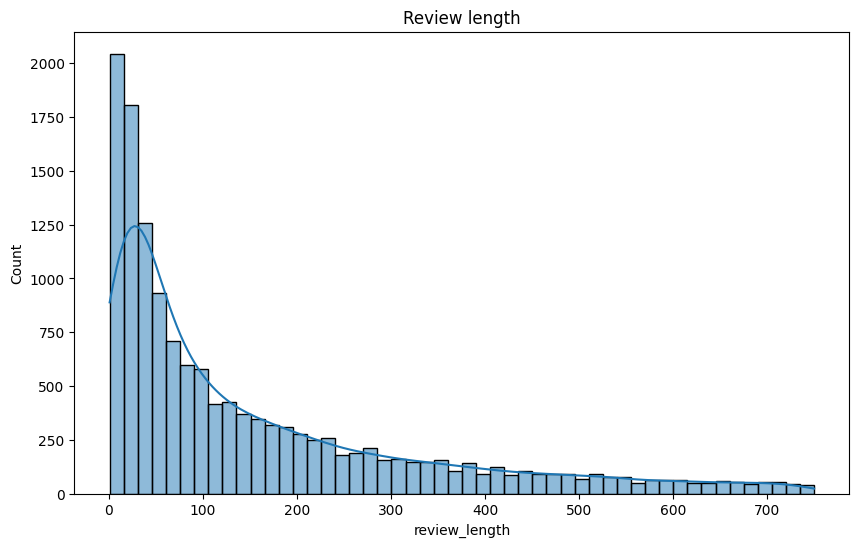

In [35]:
create_hist_plot(df, 'review_length')

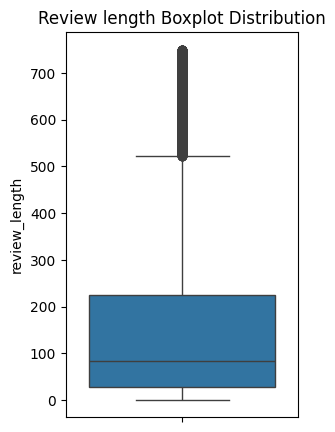

In [36]:
create_box_plot(df, 'review_length')

Interpretation
- Average review length is 309 characters
- Distribution is right-skewed

### 3.3.3 Play Hours

In [37]:
gen_info_feat(df, 'play_hours')

Description:
count    14158.000000
mean        21.355432
std         16.633486
min          0.100000
25%          8.800000
50%         17.200000
75%         31.000000
max         70.600000
Name: play_hours, dtype: float64
**************************************************
Object type: float64


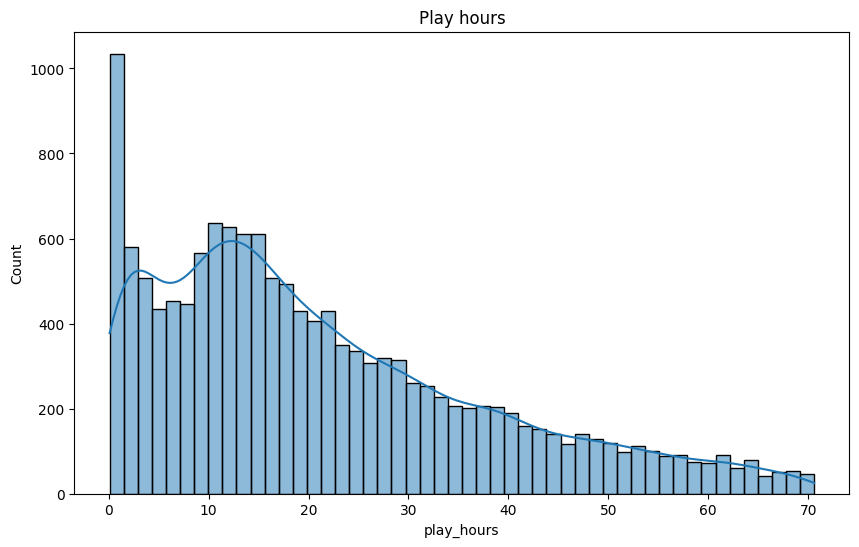

In [38]:
create_hist_plot(df, 'play_hours')

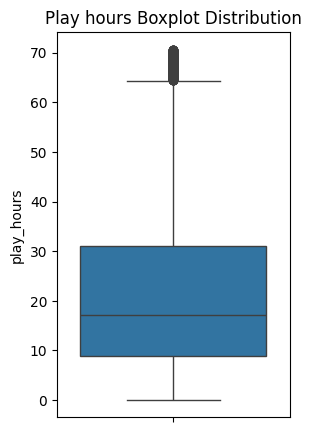

In [39]:
create_box_plot(df, 'play_hours')

Interpretation
- Average play time is roughly 25 hours
- Distribution is right-skewed
- Over 1000 reviews have less than 1 hours played

### 3.3.4 Date Posted

In [40]:
gen_info_feat(df, 'date_posted')

Description:
count          14158
unique            12
top       2024-09-14
freq            2311
Name: date_posted, dtype: object
**************************************************
Object type: object


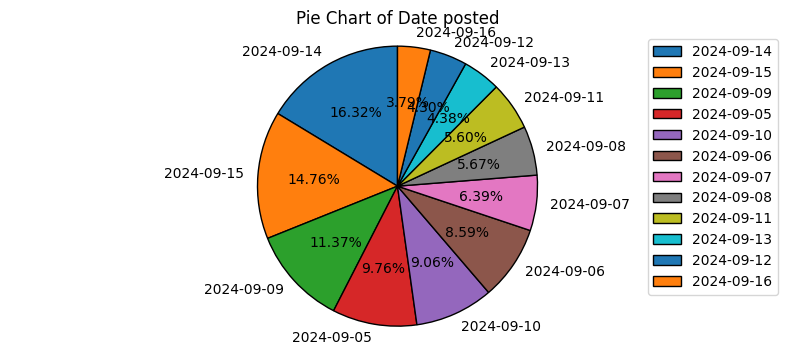

In [41]:
create_pie_plot(df, 'date_posted')

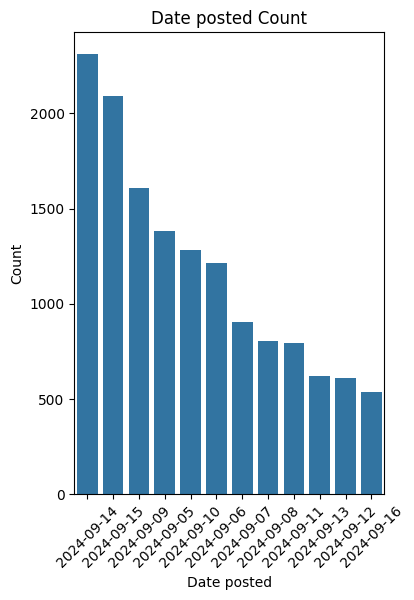

In [42]:
create_bar_plot(df, 'date_posted')

Interpretation
- Most of the reviews in the dataset were posted on September 14th
- Review counts have progressively trended downward since launch

## 3.3 Bivariate analysis

### 3.3.1 Review vs Play Hours

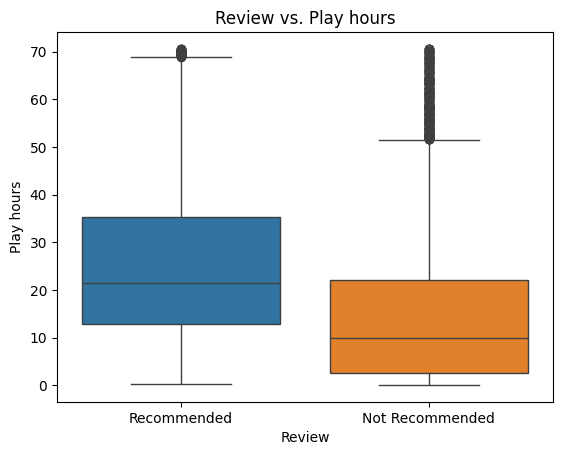

In [43]:
create_bar_plot_bi(df, 'review', 'play_hours')

Interpretation
- Recommended median time played is higher than Not Recommended
- Players who Recommended the game played longer
- Outliers show that some players do not recommend the game after playing for a large number of hours, potentially due to a lack of late-game content

### 3.3.2 Review vs Review Length

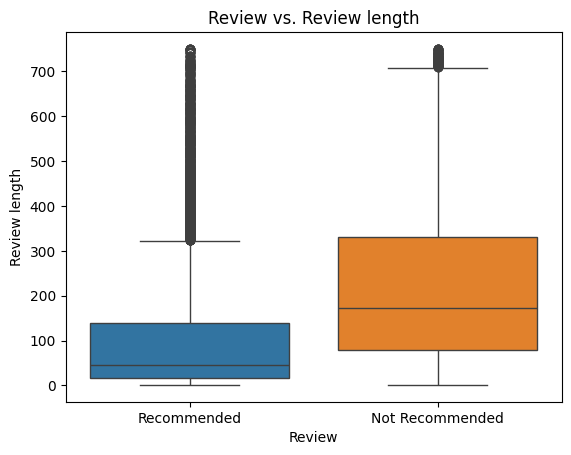

In [44]:
create_bar_plot_bi(df, 'review', 'review_length')

Interpretation
- Players who do not recommend the game typically leave longer reviews

### 3.3.3 Play Hours vs Review Length

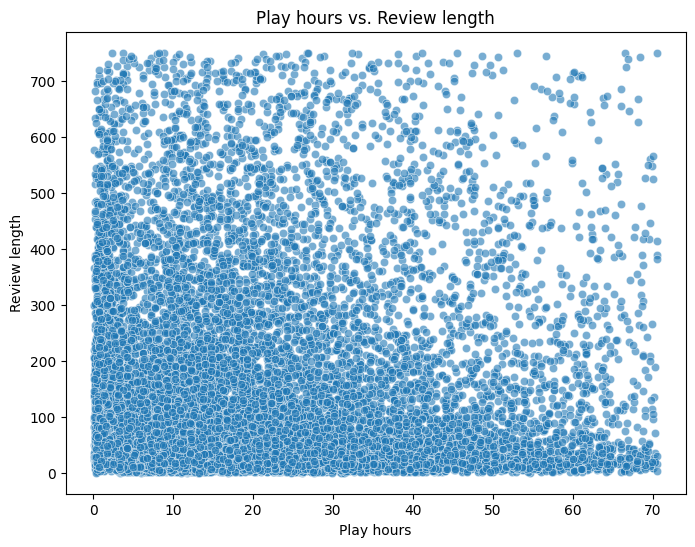

In [45]:
create_scatter_plot(df, 'play_hours', 'review_length')

Interpretation
- There is no correlation between hours played and review length

### 3.3.4 Review vs Date Posted

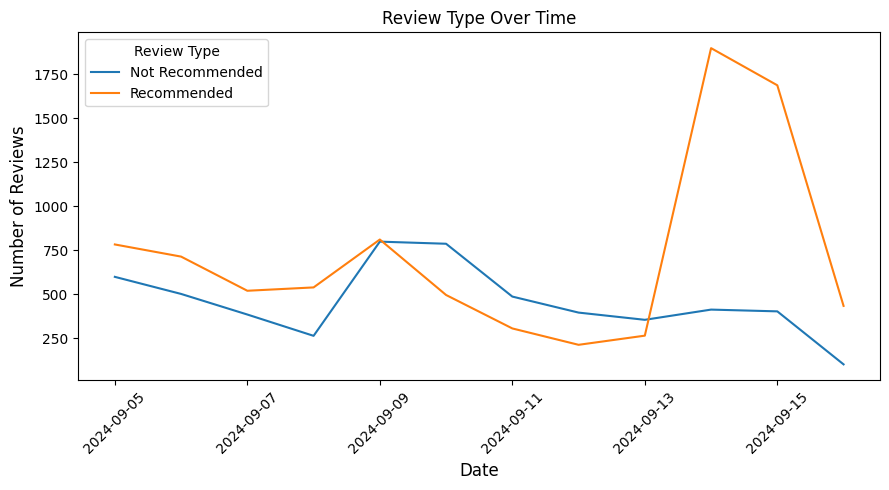

In [46]:
create_line_plot_reviews(df, 'review', 'date_posted')

Interpretation
- There was a significant boost in recommended reviews on September 13th
- Negative reviews have been fairly consistent in the first few days of launch

### 3.3.6 Correlation analysis

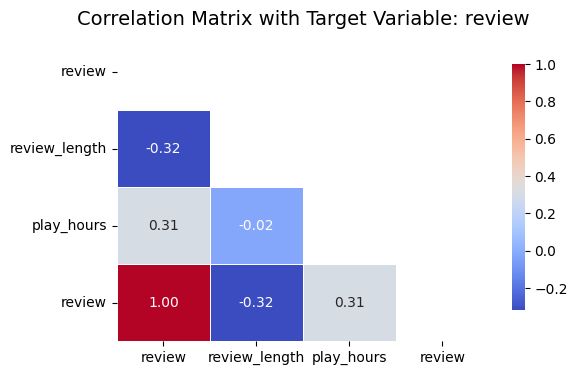

In [47]:
plot_correlation_matrix(df)

Interpretation
- Moderate negative correlation between review lengths and review type
- Moderate positive correlation between hours played and the review type

# 4. Identify Prominent Issues

## 4.1 Sentiment and aspect extraction

In [48]:
# Separate recommended and not recommended reviews
recommended_reviews = df[df['review'] == 'Recommended']['review_text']
not_recommended_reviews = df[df['review'] == 'Not Recommended']['review_text']

In [49]:
# Flatten the token lists for both categories to count word frequencies
recommended_words = list(chain.from_iterable(eval(review) for review in recommended_reviews))
not_recommended_words = list(chain.from_iterable(eval(review) for review in not_recommended_reviews))

In [50]:
# Get the most common words for each category
recommended_common_words = Counter(recommended_words).most_common(20)
not_recommended_common_words = Counter(not_recommended_words).most_common(20)

In [51]:
# Convert tokenized reviews back to text format for vectorization
recommended_reviews_text = [" ".join(eval(review)) for review in recommended_reviews]
not_recommended_reviews_text = [" ".join(eval(review)) for review in not_recommended_reviews]

## 4.2 Get top n-grams by TF-IDF

In [52]:
# Function to get top n n-grams by TF-IDF
def get_top_tfidf_ngrams(corpus, n=2, top_n=20):
    vectorizer = TfidfVectorizer(ngram_range=(n, n), stop_words='english')
    X = vectorizer.fit_transform(corpus)
    tfidf_scores = X.sum(axis=0)
    scores = [(word, tfidf_scores[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]
    return sorted_scores

In [53]:
# Apply TF-IDF to bi-grams, tri-grams, and quad-grams for both recommended and not recommended reviews
tfidf_bigrams_recommended = get_top_tfidf_ngrams(recommended_reviews_text, n=2)
tfidf_trigrams_recommended = get_top_tfidf_ngrams(recommended_reviews_text, n=3)
tfidf_bigrams_not_recommended = get_top_tfidf_ngrams(not_recommended_reviews_text, n=2)
tfidf_trigrams_not_recommended = get_top_tfidf_ngrams(not_recommended_reviews_text, n=3)

# Show top results
tfidf_bigrams_recommended, tfidf_trigrams_recommended, tfidf_bigrams_not_recommended, tfidf_trigrams_not_recommended

([('emperor protects', 152.83380401001537),
  ('good game', 108.12861014816141),
  ('great game', 107.36558452997048),
  ('space marine', 87.78844741508578),
  ('best game', 42.28301599546867),
  ('product received', 40.46198118189012),
  ('received free', 40.46198118189012),
  ('fun game', 37.75176634617131),
  ('game good', 37.60030684746221),
  ('warhammer 40k', 37.0949493938879),
  ('40k game', 35.183686473019996),
  ('feel like', 33.89810003841923),
  ('amazing game', 33.26846886893452),
  ('game year', 30.826605918693687),
  ('gear war', 27.548169427549173),
  ('game play', 26.06531044664946),
  ('game great', 23.508276716579623),
  ('god emperor', 23.417825473067325),
  ('warhammer game', 23.230174554110665),
  ('game fun', 22.568060831846545)],
 [('product received free', 41.4867557486528),
  ('blood blood god', 17.78524059458622),
  ('pledge eternal service', 17.134257031311584),
  ('battle unto anvil', 14.110164415754511),
  ('heretic kill mutant', 13.68506034014538),
  ('kil

## 4.3 Visualize n-grams

In [58]:
# Function to visualize top n-grams based on TF-IDF
def visualize_top_ngrams(ngrams, title, filename):
    # Create 'visualizations' folder if it doesn't exist
    folder_path = 'visualizations'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Save the visualization in the 'visualizations' folder
    file_path = os.path.join(folder_path, filename)
    ngrams_words, ngrams_scores = zip(*ngrams)
    
    plt.figure(figsize=(10, 6))
    plt.barh(ngrams_words, ngrams_scores, color='skyblue')
    plt.xlabel('TF-IDF Score')
    plt.title(title)
    plt.gca().invert_yaxis()  # Highest score on top
    plt.savefig(file_path, bbox_inches='tight')
    plt.show()

### 4.3.1 Recommended reviews

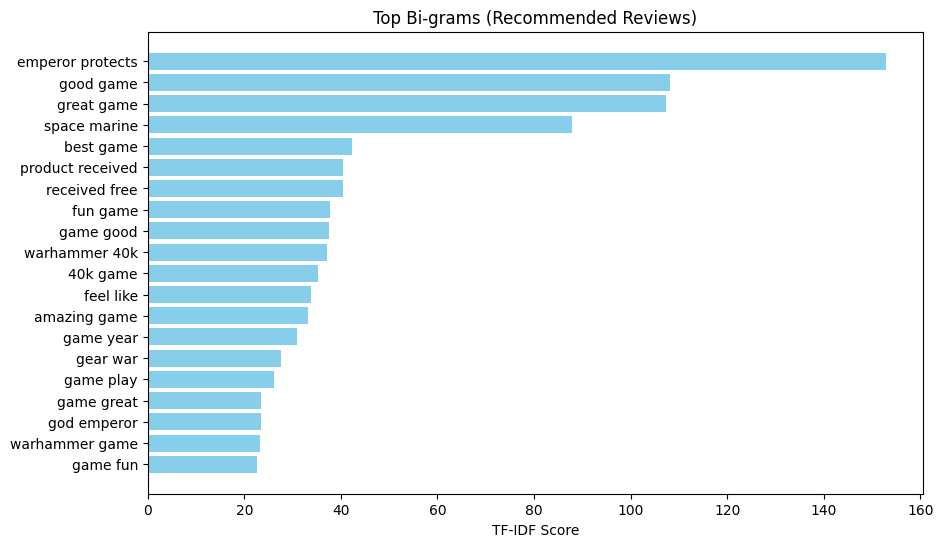

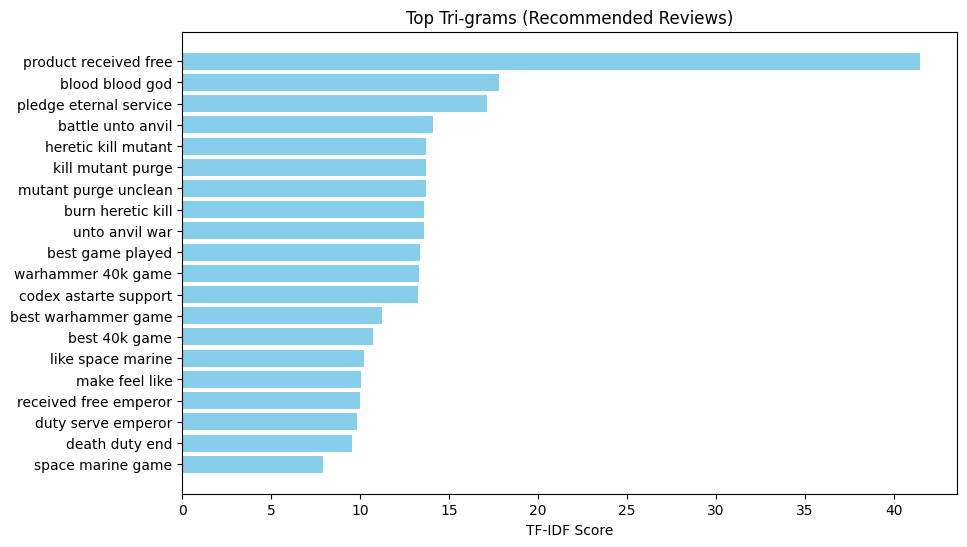

In [59]:
# Visualize the top bi-grams and tri-grams for recommended reviews
visualize_top_ngrams(tfidf_bigrams_recommended, 'Top Bi-grams (Recommended Reviews)', 'top_bigrams_recommended.png')
visualize_top_ngrams(tfidf_trigrams_recommended, 'Top Tri-grams (Recommended Reviews)', 'top_trigrams_recommended.png')

Interpretation
- Reviews highlight the immersive quality of the game but lack actual feedback of technical aspects of the title.

### 4.3.2 Not Recommended reviews

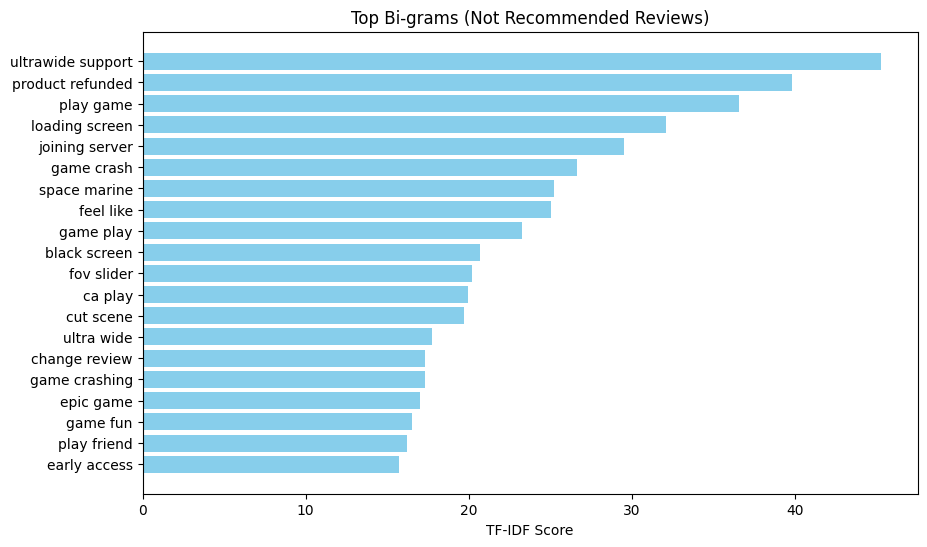

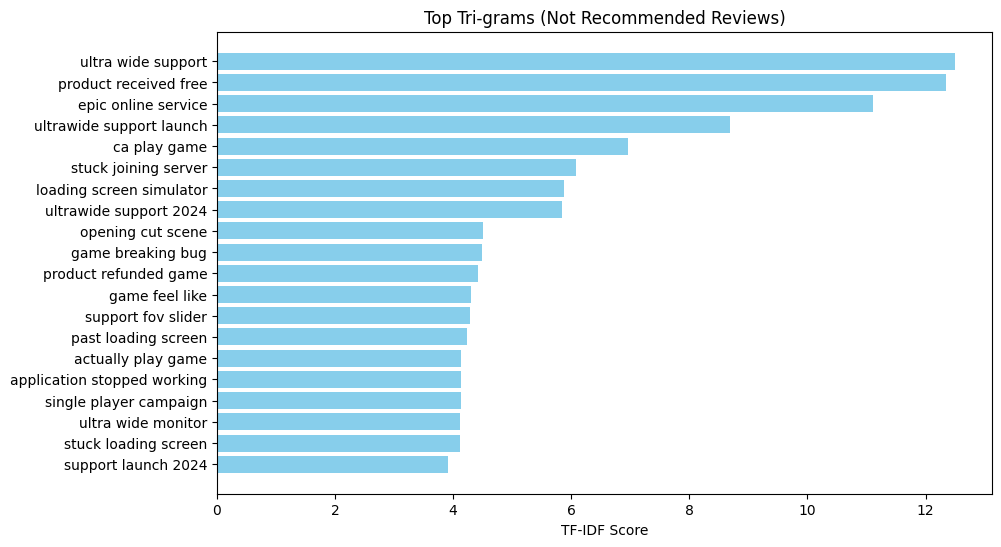

In [60]:
# Visualize the top bi-grams and tri-grams for recommended and not recommended reviews
visualize_top_ngrams(tfidf_bigrams_not_recommended, 'Top Bi-grams (Not Recommended Reviews)', 'top_bigrams_not_recommended.png')
visualize_top_ngrams(tfidf_trigrams_not_recommended, 'Top Tri-grams (Not Recommended Reviews)', 'top_trigrams_not_recommended.png')

Interpretation
- The biggest issues of the game based on player feedback stems from the lack of ultra-wide screen support, the Epic Online Services, server crashes, the lack of a "Field of View" option, and various other issues.

# 5. Findings and Recommendations

Analysis of Steam reviews highlights two key areas: overwhelmingly positive feedback around thematic immersion and gameplay, but also significant frustration due to technical issues such as ultrawide support, crashes, and server connectivity.

Positive Feedback (Recommended Reviews):

- Players appreciate the immersive Warhammer 40K experience, as shown by frequent mentions of thematic elements like 'emperor protects' and 'space marine.'
- The gameplay was widely praised, with terms like 'great game' and 'fun game' appearing frequently.

Negative Feedback (Not Recommended Reviews):

- Technical issues dominate the negative feedback, with terms like 'ultrawide support,' 'loading screen,' and 'joining server' appearing frequently.
- Frustration around game crashes and server problems is widespread, making these key areas for improvement.

## 5.1 Actionable recommendations

Technical Improvements: 
- Prioritize fixes around ultrawide support, server stability, and crash issues based on the feedback analysis.

Leverage Positive Feedback: 
- Use the strong thematic connection in marketing and social media to attract more Warhammer fans (e.g., "Emperor Protects" could be a tagline).